In [2]:
!pip install tensorflow==2.8.0 tensorflow-hub==0.12.0


In [3]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cambiar a la ruta donde está el archivo zip principal en Google Drive
%cd /content/drive/MyDrive

# Descomprimir el archivo zip principal
!unzip micorrizas_dataset.zip -d /content/Dataset_zip

# Importar las bibliotecas necesarias
import os
import zipfile

# Ruta donde se descomprimieron los archivos zip
path_to_zips = '/content/Dataset_zip'

# Crear un listado de todos los archivos zip
zip_files = [f for f in os.listdir(path_to_zips) if f.endswith('.zip')]

for zip_file in zip_files:
    # Obtener el nombre del archivo sin la extensión
    folder_name = os.path.splitext(zip_file)[0]

    # Crear la carpeta con el nombre del archivo zip
    os.makedirs(os.path.join(path_to_zips, folder_name), exist_ok=True)

    # Ruta completa del archivo zip
    zip_file_path = os.path.join(path_to_zips, zip_file)

    # Descomprimir el archivo zip en su carpeta respectiva
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(path_to_zips, folder_name))

    # Eliminar el archivo zip después de descomprimirlo
    os.remove(zip_file_path)

# Verificación
for folder in os.listdir(path_to_zips):
    print(f"Carpeta {folder} contiene {len(os.listdir(os.path.join(path_to_zips, folder)))} archivos")


Mounted at /content/drive
/content/drive/MyDrive
Archive:  micorrizas_dataset.zip
 extracting: /content/Dataset_zip/Ectomicorriza.zip  
 extracting: /content/Dataset_zip/Endomicorriza.zip  
Carpeta Ectomicorriza contiene 539 archivos
Carpeta Endomicorriza contiene 552 archivos


Found 874 images belonging to 2 classes.
Found 217 images belonging to 2 classes.


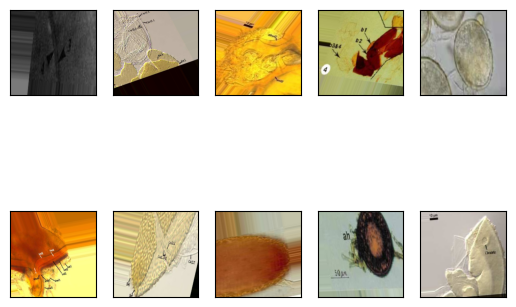

In [4]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt # Import the matplotlib library

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/Dataset_zip', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/Dataset_zip', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


In [6]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [7]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [8]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2, activation='softmax')
])

In [9]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
#Compilar como siempre
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
#Entrenar el modelo
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/50
55/55 [==============================] - 136s 2s/step - loss: 0.7163 - accuracy: 0.5965 - val_loss: 0.6184 - val_accuracy: 0.6483
Epoch 2/50
55/55 [==============================] - 129s 2s/step - loss: 0.6180 - accuracy: 0.6709 - val_loss: 0.6194 - val_accuracy: 0.6759
Epoch 3/50
55/55 [==============================] - 128s 2s/step - loss: 0.5583 - accuracy: 0.7184 - val_loss: 0.5867 - val_accuracy: 0.7034
Epoch 4/50
55/55 [==============================] - 123s 2s/step - loss: 0.5256 - accuracy: 0.7378 - val_loss: 0.5639 - val_accuracy: 0.7287
Epoch 5/50
55/55 [==============================] - 122s 2s/step - loss: 0.4904 - accuracy: 0.7521 - val_loss: 0.5364 - val_accuracy: 0.7241
Epoch 6/50
55/55 [==============================] - 131s 2s/step - loss: 0.5120 - accuracy: 0.7533 - val_loss: 0.5398 - val_accuracy: 0.7195
Epoch 7/50
55/55 [==============================] - 127s 2s/step - loss: 0.4976 - accuracy: 0.7630 - val_loss: 0.5175 - val_accuracy: 0.7402
Epoch 8/50
55

In [12]:
# Obtener la precisión final en el conjunto de entrenamiento y de validación
train_accuracy = historial.history['accuracy'][-1] * 100
val_accuracy = historial.history['val_accuracy'][-1] * 100

# Mostrar las precisiones
print(f"Precisión final en el conjunto de entrenamiento: {train_accuracy:.2f}%")
print(f"Precisión final en el conjunto de validación: {val_accuracy:.2f}%")


Precisión final en el conjunto de entrenamiento: 81.34%
Precisión final en el conjunto de validación: 78.85%


In [ ]:
#Categorizar una imagen de internet
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
    respuesta = requests.get(url)
    img = Image.open(BytesIO(respuesta.content))
    img = np.array(img).astype(float)/255
    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
    return np.argmax(prediccion[0], axis=-1)

# Mapear las predicciones a las categorías deseadas
categorias = {0: 'Ectomicorriza', 1: 'Endomicorriza'}

In [ ]:
#DEBE SALIR ECTOMICORRIZA
# URL de la imagen que deseas categorizar
url = 'https://invam.ku.edu/sites/invam/files/images/species/Acaulospora/morrowiae/L1-L2-and-L3-of-spore-wall-gw1-gw2-2.jpeg'

# Obtener la predicción
prediccion = categorizar(url)

# Imprimir la categoría correspondiente
print(categorias[prediccion])

Ectomicorriza


In [ ]:
#Crear la carpeta para exportarla a TF Serving
!mkdir -p carpeta_salida/modelo_micorriza/1

In [ ]:
#Guardar el modelo en formato SavedModel
modelo.save('carpeta_salida/modelo_micorriza/1')

In [ ]:
#Hacerlo un zip para bajarlo y usarlo en otro lado
!zip -r modelo_micorriza.zip /content/drive/MyDrive/carpeta_salida/

  adding: content/drive/MyDrive/carpeta_salida/ (stored 0%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_cocina/ (stored 0%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_cocina/1/ (stored 0%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_cocina/1/variables/ (stored 0%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_cocina/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_cocina/1/variables/variables.index (deflated 78%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_cocina/1/assets/ (stored 0%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_cocina/1/saved_model.pb (deflated 91%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_cocina/1/fingerprint.pb (stored 0%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_cocina/1/keras_metadata.pb (deflated 80%)
  adding: content/drive/MyDrive/carpeta_salida/modelo_micorriza/ (stored 0%)
  adding: content/drive/MyDrive/carpeta_sali

In [ ]:
import tensorflow as tf

# Después de entrenar el modelo
modelo.save('mi_modelo.h5')

# Generar un enlace de descarga
from google.colab import files
files.download('mi_modelo.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Instalar TensorFlow.js
!pip install tensorflowjs

# Convertir el modelo Keras .h5 a TensorFlow.js
!mkdir carpeta_salida
!tensorflowjs_converter --input_format keras mi_modelo.h5 carpeta_salida

# Descargar los archivos convertidos
from google.colab import files
import os

output_dir = 'carpeta_salida'
for filename in os.listdir(output_dir):
    files.download(os.path.join(output_dir, filename))


mkdir: cannot create directory ‘carpeta_salida’: File exists
2024-08-23 19:40:54.758758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 19:40:54.787416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 19:40:54.795375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 19:40:56.235395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>